In [16]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List, Iterable, Tuple, Dict

from pyutils.io.tensorboard import parse_tensorboard_as_list
from pyutils.base.path import listdir_fullpath
from pyutils.base import log, dict_map

mpl.rcParams.update({'font.size': 20,
                     'font.family': 'serif',
                     'lines.markersize': 8})

FIGSIZE = (8, 8)
COLORSCHEME = np.array(['#8ECFC9', '#FFBE7A', '#FA7F6F',
                        '#82B0D2', '#BEB8DC', '#E7DAD2', '#999999'])
ALPHA = 0.3


## Loading Data

In [17]:
def load_party_map() -> Dict[str, List[str]]:
    """
    Returns:
        dict:
            { setting: list of parties }
    """
    data_dir = 'data/fashion_mnist'
    party_map = {}
    for setting in 'ABCD':
        party_map[setting] = sorted(
            os.listdir(os.path.join(data_dir, setting)))
    return party_map


party_map = load_party_map()


compute the accuracy of centralized baseline

In [18]:
def get_centralized_log_dir(version: int):
    dir = f'output/fashion_mnist/baseline/log/version_{version}'
    assert os.path.isdir(dir)
    return dir


def load_centralized_train_acc_by_version(version: int):
    epoch, train_acc = parse_tensorboard_as_list(
        get_centralized_log_dir(version), ['epoch', 'train_acc'])

    epoch_idx = np.arange(20)
    step_idx = np.array([epoch[epoch['value'] == i]['step'].max()
                         for i in epoch_idx])
    epoch_acc = train_acc[train_acc['step'].isin(step_idx)]['value'].to_numpy()
    return epoch_acc


def load_centralized_train_acc() -> Tuple[np.ndarray, np.ndarray]:
    epoch_acc = np.array([load_centralized_train_acc_by_version(version)
                          for version in range(20)])  # (num_version , num_epoch)
    mean = epoch_acc.mean(0)
    std = epoch_acc.std(0)
    return mean, std


def load_centralized_test_acc():
    df = pd.read_csv('output/fashion_mnist/baseline/result.csv')['test_acc']
    return df.mean(), df.std()


centralized_mean, centralized_std = load_centralized_test_acc()
CENTRALIZED_ACC = centralized_mean


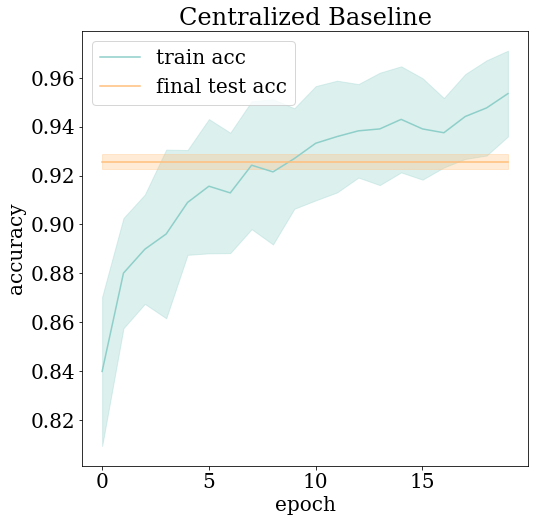

In [19]:
fig, ax = plt.subplots(figsize=FIGSIZE)

mean, std = load_centralized_train_acc()
assert len(mean) == len(std)
x = np.arange(len(mean))

ax.plot(x, mean, c=COLORSCHEME[0], label=f'train acc')
ax.fill_between(x, mean - std, mean + std,
                color=COLORSCHEME[0], alpha=ALPHA)

x = [0, len(mean) - 1]
ax.plot(x, [centralized_mean] * 2, c=COLORSCHEME[1], label='final test acc')
ax.fill_between(x, [centralized_mean - centralized_std] * 2, [centralized_mean + centralized_std] * 2,
                color=COLORSCHEME[1], alpha=ALPHA)

ax.set_title('Centralized Baseline')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend()
plt.show()


load result of ours

In [20]:
def get_calibration_log_dir(setting: str, version: int):
    dir = f'output/fashion_mnist/global/calibration/log/{setting}/{version}/version_0'
    assert os.path.isdir(dir), f'`{dir}` is not a directory.'
    return dir


def get_raw_log_dir(setting: str, version: int):
    dir = f'output/fashion_mnist/global/raw/log/{setting}/version_{version}'
    assert os.path.isdir(dir), f'`{dir}` is not a directory.'
    return dir


def load_calibration_test_acc_by_version(setting, version):
    log_dir = get_calibration_log_dir(setting, version)
    test_acc, val_acc = parse_tensorboard_as_list(
        log_dir, ['test_acc', 'val_acc'])
    test_acc = pd.concat((test_acc,val_acc))
    test_acc = test_acc['value'].to_numpy()
    return test_acc


def load_calibration_test_acc():
    result = {}
    for setting in 'ABCD':
        test_acc = np.array([load_calibration_test_acc_by_version(
            setting, version) for version in range(20)])
        result[setting] = test_acc.mean(0), test_acc.std(0)
    return result


def load_raw_test_acc_by_version(setting, version):
    log_dir = get_raw_log_dir(setting, version)
    test_acc, val_acc = parse_tensorboard_as_list(
        log_dir, ['test_acc', 'val_acc'])
    test_acc = pd.concat((test_acc,val_acc))
    test_acc = test_acc['value'].to_numpy()
    return test_acc


def load_raw_test_acc():
    result = {}
    for setting in 'ABCD':
        test_acc = np.array([load_raw_test_acc_by_version(
            setting, version) for version in range(20)])
        result[setting] = test_acc.mean(0), test_acc.std(0)
    return result


# calibration
ours_calibration_data = load_calibration_test_acc()
# zero-shot accuracy
ours_deploy_data = dict_map(
    lambda ms: (ms[0][0], ms[1][0]), ours_calibration_data)
# calibrate global model from random initialization
ours_raw_data = load_raw_test_acc()


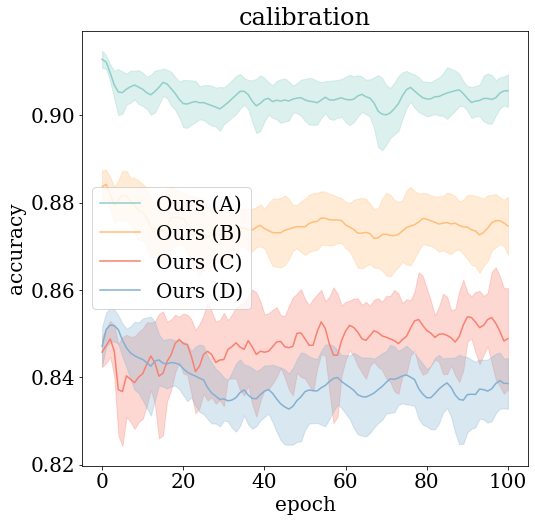

In [21]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for i, setting in enumerate('ABCD'):
    mean, std = ours_calibration_data[setting]
    assert len(mean) == len(std)
    x = np.arange(len(mean))

    ax.plot(x, mean, c=COLORSCHEME[i], label=f'Ours ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

ax.set_title('calibration')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend()
plt.show()


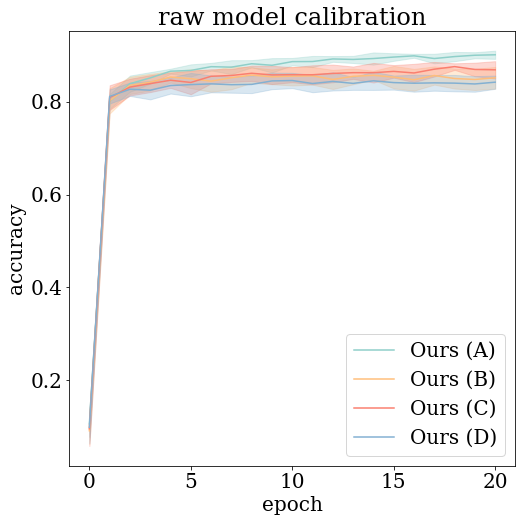

In [22]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for i, setting in enumerate('ABCD'):
    mean, std = ours_raw_data[setting]
    assert len(mean) == len(std)
    x = np.arange(len(mean))

    ax.plot(x, mean, c=COLORSCHEME[i], label=f'Ours ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

ax.set_title('raw model calibration')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend()
plt.show()


load result of HMR

In [23]:
def load_hmr_data():
    """
    Returns:
        dict: { setting: (mean, std) }
    """
    hmr_df = pd.read_csv('output/fashion_mnist.HMR/result.csv')
    hmr_df_mean = hmr_df.groupby(['Setting', 'Iteration']).mean()['Accuracy']
    hmr_df_std = hmr_df.groupby(['Setting', 'Iteration']).std()['Accuracy']
    hmr = {}
    for setting, name in zip('ABCD', ['2 parties – B', '3 parties – A', '3 parties – B', '7 parties']):
        mean = hmr_df_mean[name].to_numpy()
        std = hmr_df_std[name].to_numpy()
        hmr[setting] = (mean, std)
    return hmr


hmr_data = load_hmr_data()


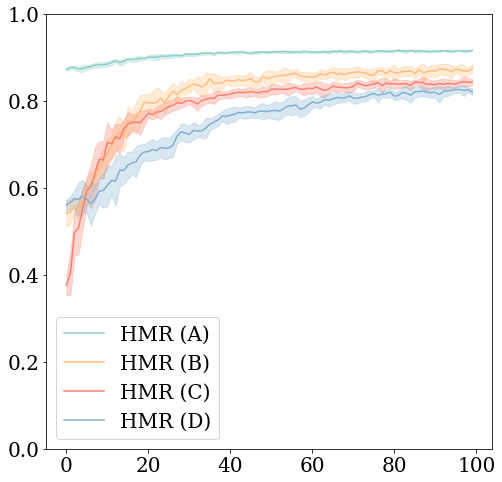

In [24]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for i, setting in enumerate('ABCD'):
    mean, std = hmr_data[setting]
    assert len(mean) == len(std)
    x = np.arange(len(mean))

    ax.plot(x, mean, c=COLORSCHEME[i], label=f'HMR ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

ax.set_ylim(0, 1)
ax.legend()
plt.show()


load result of RKME

In [25]:
"""
Deployment Phase
"""


def get_RKME_deplyment_result_dir(setting: str, version: int):
    return f'output/fashion_mnist.RKME/features.resnet101.RKME.M=10/deploy/{setting}/version_{version}'


def load_RKME_accuracy(setting: str, version: int):
    log_dir = get_RKME_deplyment_result_dir(setting, version)
    result_file = os.path.join(log_dir, 'result.csv')
    if not os.path.isfile(result_file):
        log.error(f"Cannot find result file '{result_file}.'")
        raise FileNotFoundError()
    result_df = pd.read_csv(result_file)
    accuracy = result_df['acc'].item()
    return accuracy


def load_RKME_data() -> dict[str, Tuple[float, float]]:
    """
    Returns:
        dict[str, Tuple[float, float]]: 
            { setting: (mean, std) } - mean and std are single float here
    """
    result = {}
    for setting in 'ABCD':
        acc = []
        for version in range(20):
            try:
                acc.append(load_RKME_accuracy(setting, version))
            except:
                continue
        log.info(f'load {len(acc)} versions data of setting {setting}.')
        result[setting] = np.mean(acc), np.std(acc)
    return result


rkme_data = load_RKME_data()


INFO: load 20 versions data of setting A.
INFO: load 20 versions data of setting B.
INFO: load 20 versions data of setting C.
INFO: load 20 versions data of setting D.


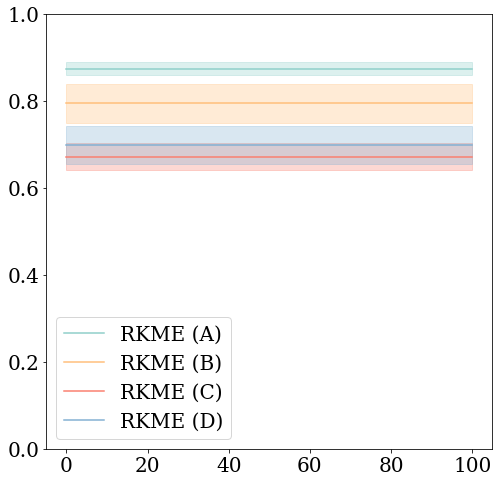

In [26]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for i, setting in enumerate('ABCD'):
    mean, std = rkme_data[setting]
    mean = np.array([mean, mean])
    std = np.array([std, std])
    x = np.array([0, 100])

    ax.plot(x, mean, c=COLORSCHEME[i], label=f'RKME ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

ax.set_ylim(0, 1)
ax.legend()
plt.show()


## Plot

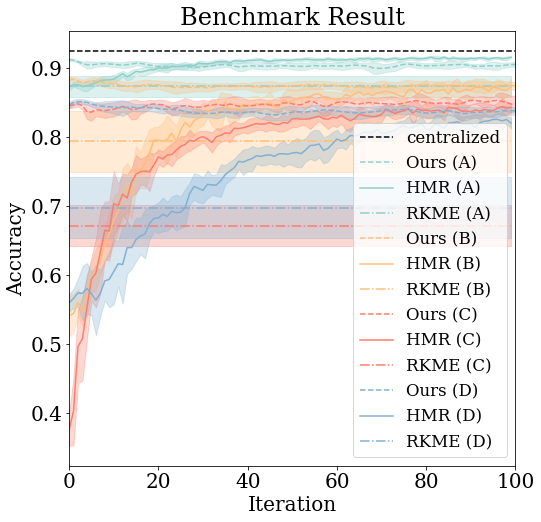

In [27]:
fig, ax = plt.subplots(figsize=FIGSIZE)
# Baseline
x = [0, 100]
ax.plot(x, [CENTRALIZED_ACC, CENTRALIZED_ACC],
        '--', color='k', label='centralized')

for i, setting in enumerate('ABCD'):
    # Ours
    mean, std = ours_calibration_data[setting]
    x = np.arange(len(mean))
    ax.plot(x, mean, '--',
            c=COLORSCHEME[i], label=f'Ours ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

    # HMR
    mean, std = hmr_data[setting]
    x = np.arange(len(mean))
    ax.plot(x, mean,
            c=COLORSCHEME[i], label=f'HMR ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

    # RKME
    mean, std = rkme_data[setting]
    mean, std = np.array([mean] * 2), np.array([std] * 2)
    x = [x[0], x[-1]]
    ax.plot(x, mean, '-.',
            c=COLORSCHEME[i], label=f'RKME ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

ax.set_title('Benchmark Result')
ax.legend(loc='lower right', fontsize='small')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_xlim(0, 100)
plt.savefig(f'output/images/benchmark.pdf')
plt.show()


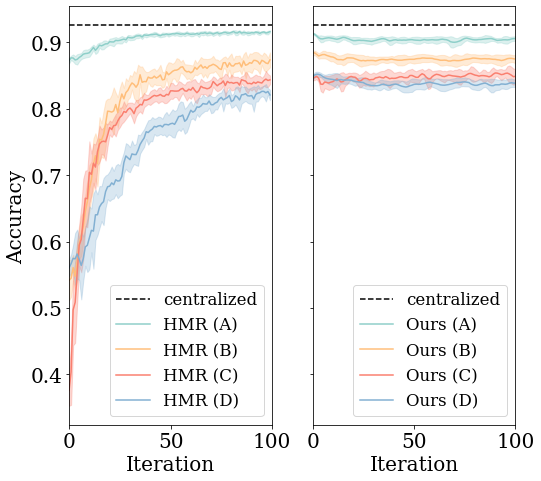

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(8, 7.7))

# Baseline
for ax in axes:
    x = [0, 100]
    ax.plot(x, [CENTRALIZED_ACC, CENTRALIZED_ACC],
            '--', color='k', label='centralized')

# left
ax = axes[0]
for i, setting in enumerate('ABCD'):
    # HMR
    mean, std = hmr_data[setting]
    x = np.arange(len(mean))
    ax.plot(x, mean, c=COLORSCHEME[i], label=f'HMR ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)


# right
ax = axes[1]
for i, setting in enumerate('ABCD'):
    # #RKME
    # x = [0, 100]
    # mean, std = rkme_data[setting]
    # mean, std = np.array([mean] * 2), np.array([std] * 2)
    # ax.plot(x, mean, '--',
    #         c=COLORSCHEME[i], label=f'RKME ({setting})')
    # ax.fill_between(x, mean - std, mean + std,
    #                 color=COLORSCHEME[i], alpha=ALPHA)

    # Ours
    mean, std = ours_calibration_data[setting]
    x = np.arange(len(mean))
    ax.plot(x, mean, c=COLORSCHEME[i], label=f'Ours ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[i], alpha=ALPHA)

axes[0].set_ylabel('Accuracy')
axes[1].set_ylim(axes[0].get_ylim())
for label in axes[1].get_yticklabels():
    label.set_visible(False)


for ax in axes:
    ax.legend(loc='lower right', fontsize='small')
    ax.set_xlabel('Iteration')
    ax.set_xlim(0, 100)

plt.savefig(f'output/images/benchmark_HMR_Ours.pdf')
plt.show()


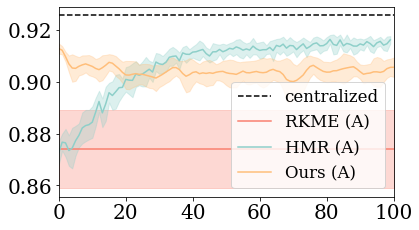

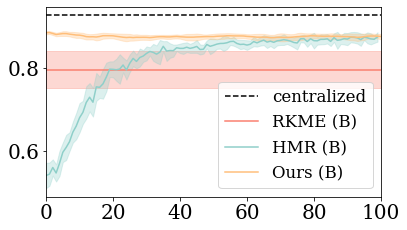

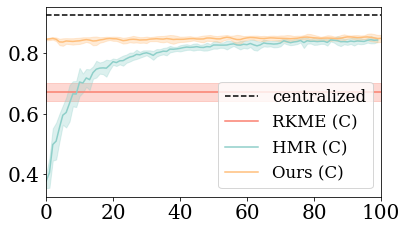

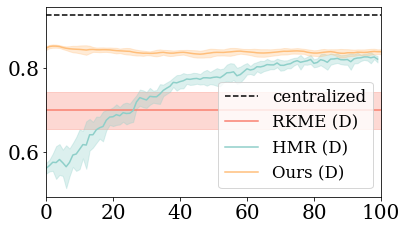

In [29]:
for i, setting in enumerate('ABCD'):
    fig, ax = plt.subplots(figsize=(6, 3.5))

    # Baseline
    x = [0, 100]
    ax.plot(x, [CENTRALIZED_ACC, CENTRALIZED_ACC],
            '--', color='k', label='centralized')

    # RKME
    x = [0, 100]
    mean, std = rkme_data[setting]
    mean, std = np.array([mean] * 2), np.array([std] * 2)
    ax.plot(x, mean, c=COLORSCHEME[2], label=f'RKME ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[2], alpha=ALPHA)

    # HMR
    mean, std = hmr_data[setting]
    x = np.arange(len(mean))
    ax.plot(x, mean, c=COLORSCHEME[0], label=f'HMR ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[0], alpha=ALPHA)

    # Ours
    mean, std = ours_calibration_data[setting]
    x = np.arange(len(mean))
    ax.plot(x, mean, c=COLORSCHEME[1], label=f'Ours ({setting})')
    ax.fill_between(x, mean - std, mean + std,
                    color=COLORSCHEME[1], alpha=ALPHA)
    # ax.plot([0, 100], [mean[0], mean[0]], '-.', color='green', alpha=0.7, label=f'Ours-ZeroShot ({labels[i]})')

    ax.legend(loc='lower right', fontsize='small')
    ax.set_xlim(0, 100)
    # ax.set_title(labels[i])
    plt.savefig(f'output/images/benchmark_{setting}.pdf')
    plt.show()


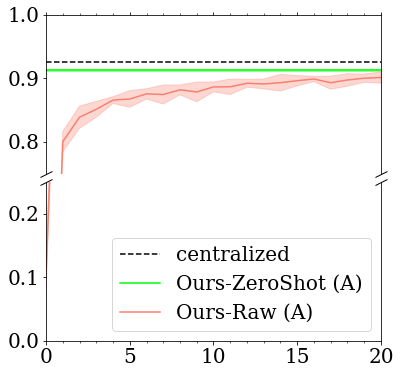

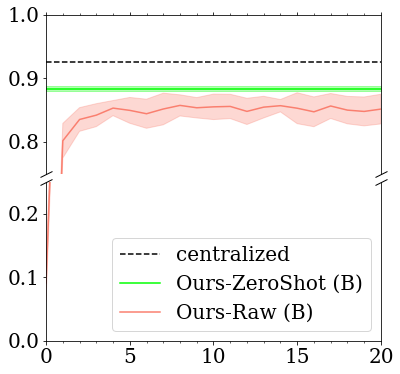

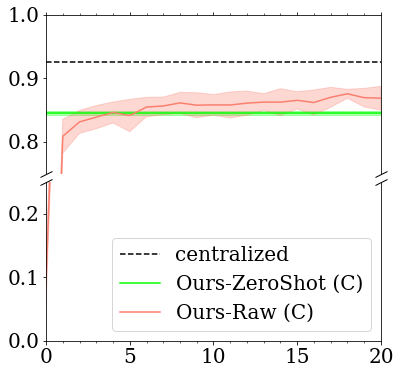

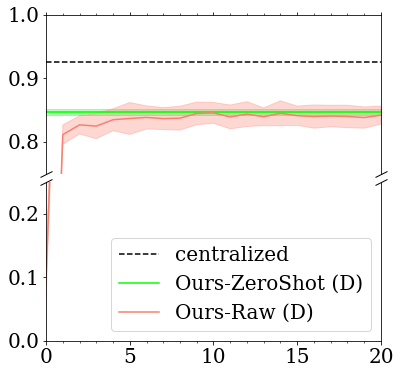

In [30]:
for i, setting in enumerate('ABCD'):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
    fig.subplots_adjust(hspace=0.05)  # adjust space between axes

    # plot the same data on both axes
    for ax in (ax1, ax2):
        # Baseline
        x = [0, 20]
        ax.plot(x, [CENTRALIZED_ACC, CENTRALIZED_ACC],
                '--', color='k', label='centralized')

        # ours zero-shot performance
        mean, std = ours_deploy_data[setting]
        mean, std = map(lambda x: np.array([x, x]), (mean, std))
        x = [0, 20]
        ax.plot(x, mean, '-', color='#00FF00',
                label=f'Ours-ZeroShot ({setting})')
        ax.fill_between(x, mean - std, mean + std,
                        color='#00FF00', alpha=ALPHA)

        # from raw
        mean, std = ours_raw_data[setting]
        x = np.arange(len(mean))
        ax.plot(x, mean, c=COLORSCHEME[2], label=f'Ours-Raw ({setting})')
        ax.fill_between(x, mean - std, mean + std,
                        color=COLORSCHEME[2], alpha=ALPHA)

        ax.set_xlim(0, 20)

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    ax1.set_ylim(0.75, 1)
    ax2.set_ylim(0, 0.25)
    ax2.legend(loc='lower right')
    plt.savefig(f'output/images/benchmark_raw_{setting}.pdf')
    plt.show()
